In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
import sksurv as sks
from sksurv.nonparametric import kaplan_meier_estimator#
warnings.filterwarnings("ignore")

## Data import and preprocessing

In [18]:
data = pd.read_csv('./dataset/Aids/actg320.csv',header=None)
HIV = pd.DataFrame(data)
HIV.columns = ["time","censor","time_d","censor_d","tx","txgrp","strat2","sex","raceth",
              "ivdrug","hemophil","karnof","cd4","priorzdv","age"]
HIV = HIV.drop(["time_d","censor_d","txgrp","hemophil"],axis=1)
HIV.head()


,time,censor,tx,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,189,0,0,1,1,1,1,100,169.0,39.0,34
1,287,0,0,1,2,2,1,90,149.5,15.0,34
2,242,0,1,0,1,1,1,100,23.5,9.0,20
3,199,0,0,1,1,1,1,90,46.0,53.0,48
4,286,0,1,0,1,1,3,90,10.0,12.0,46


In [19]:
HIV['ivdrug'] = 1 * (HIV['ivdrug'] > 1)

In [20]:
HIV['time'] = HIV['time']/7.

In [21]:
print(np.unique(HIV['raceth']))
HIV['raceth'] = HIV['raceth'].replace({5: 4})
print(np.unique(HIV['raceth']))

[1 2 3 4 5]
[1 2 3 4]


In [22]:
HIV.describe()

,time,censor,tx,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
count,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000
mean,32.883331,0.083406,0.498697,0.618593,1.173762,1.701998,0.158992,91.303215,86.459745,30.419157,38.647263
std,12.839588,0.276615,0.500216,0.485943,0.379069,0.832380,0.365828,7.726025,70.054330,29.217779,8.811395
min,0.142857,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,70.000000,0.000000,3.000000,15.000000
25%,24.857143,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,90.000000,23.000000,10.000000,33.000000
50%,36.714286,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,90.000000,74.500000,21.000000,38.000000
75%,42.857143,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,100.000000,136.500000,42.000000,44.000000
max,52.000000,1.000000,1.000000,1.000000,2.000000,4.000000,1.000000,100.000000,392.000000,312.000000,73.000000


In [23]:
dataset_name = "Aids"
data_file= "./dataset/" + dataset_name + "/data.csv"
HIV.to_csv(data_file,header=False,index=False)

In [24]:
from utils import data_processing, visualization, statistic



feat_types_file = "./dataset/" + dataset_name + "/data_types.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "./dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

survcens
tx
strat2
sex
raceth
ivdrug
karnof
cd4
priorzdv
age


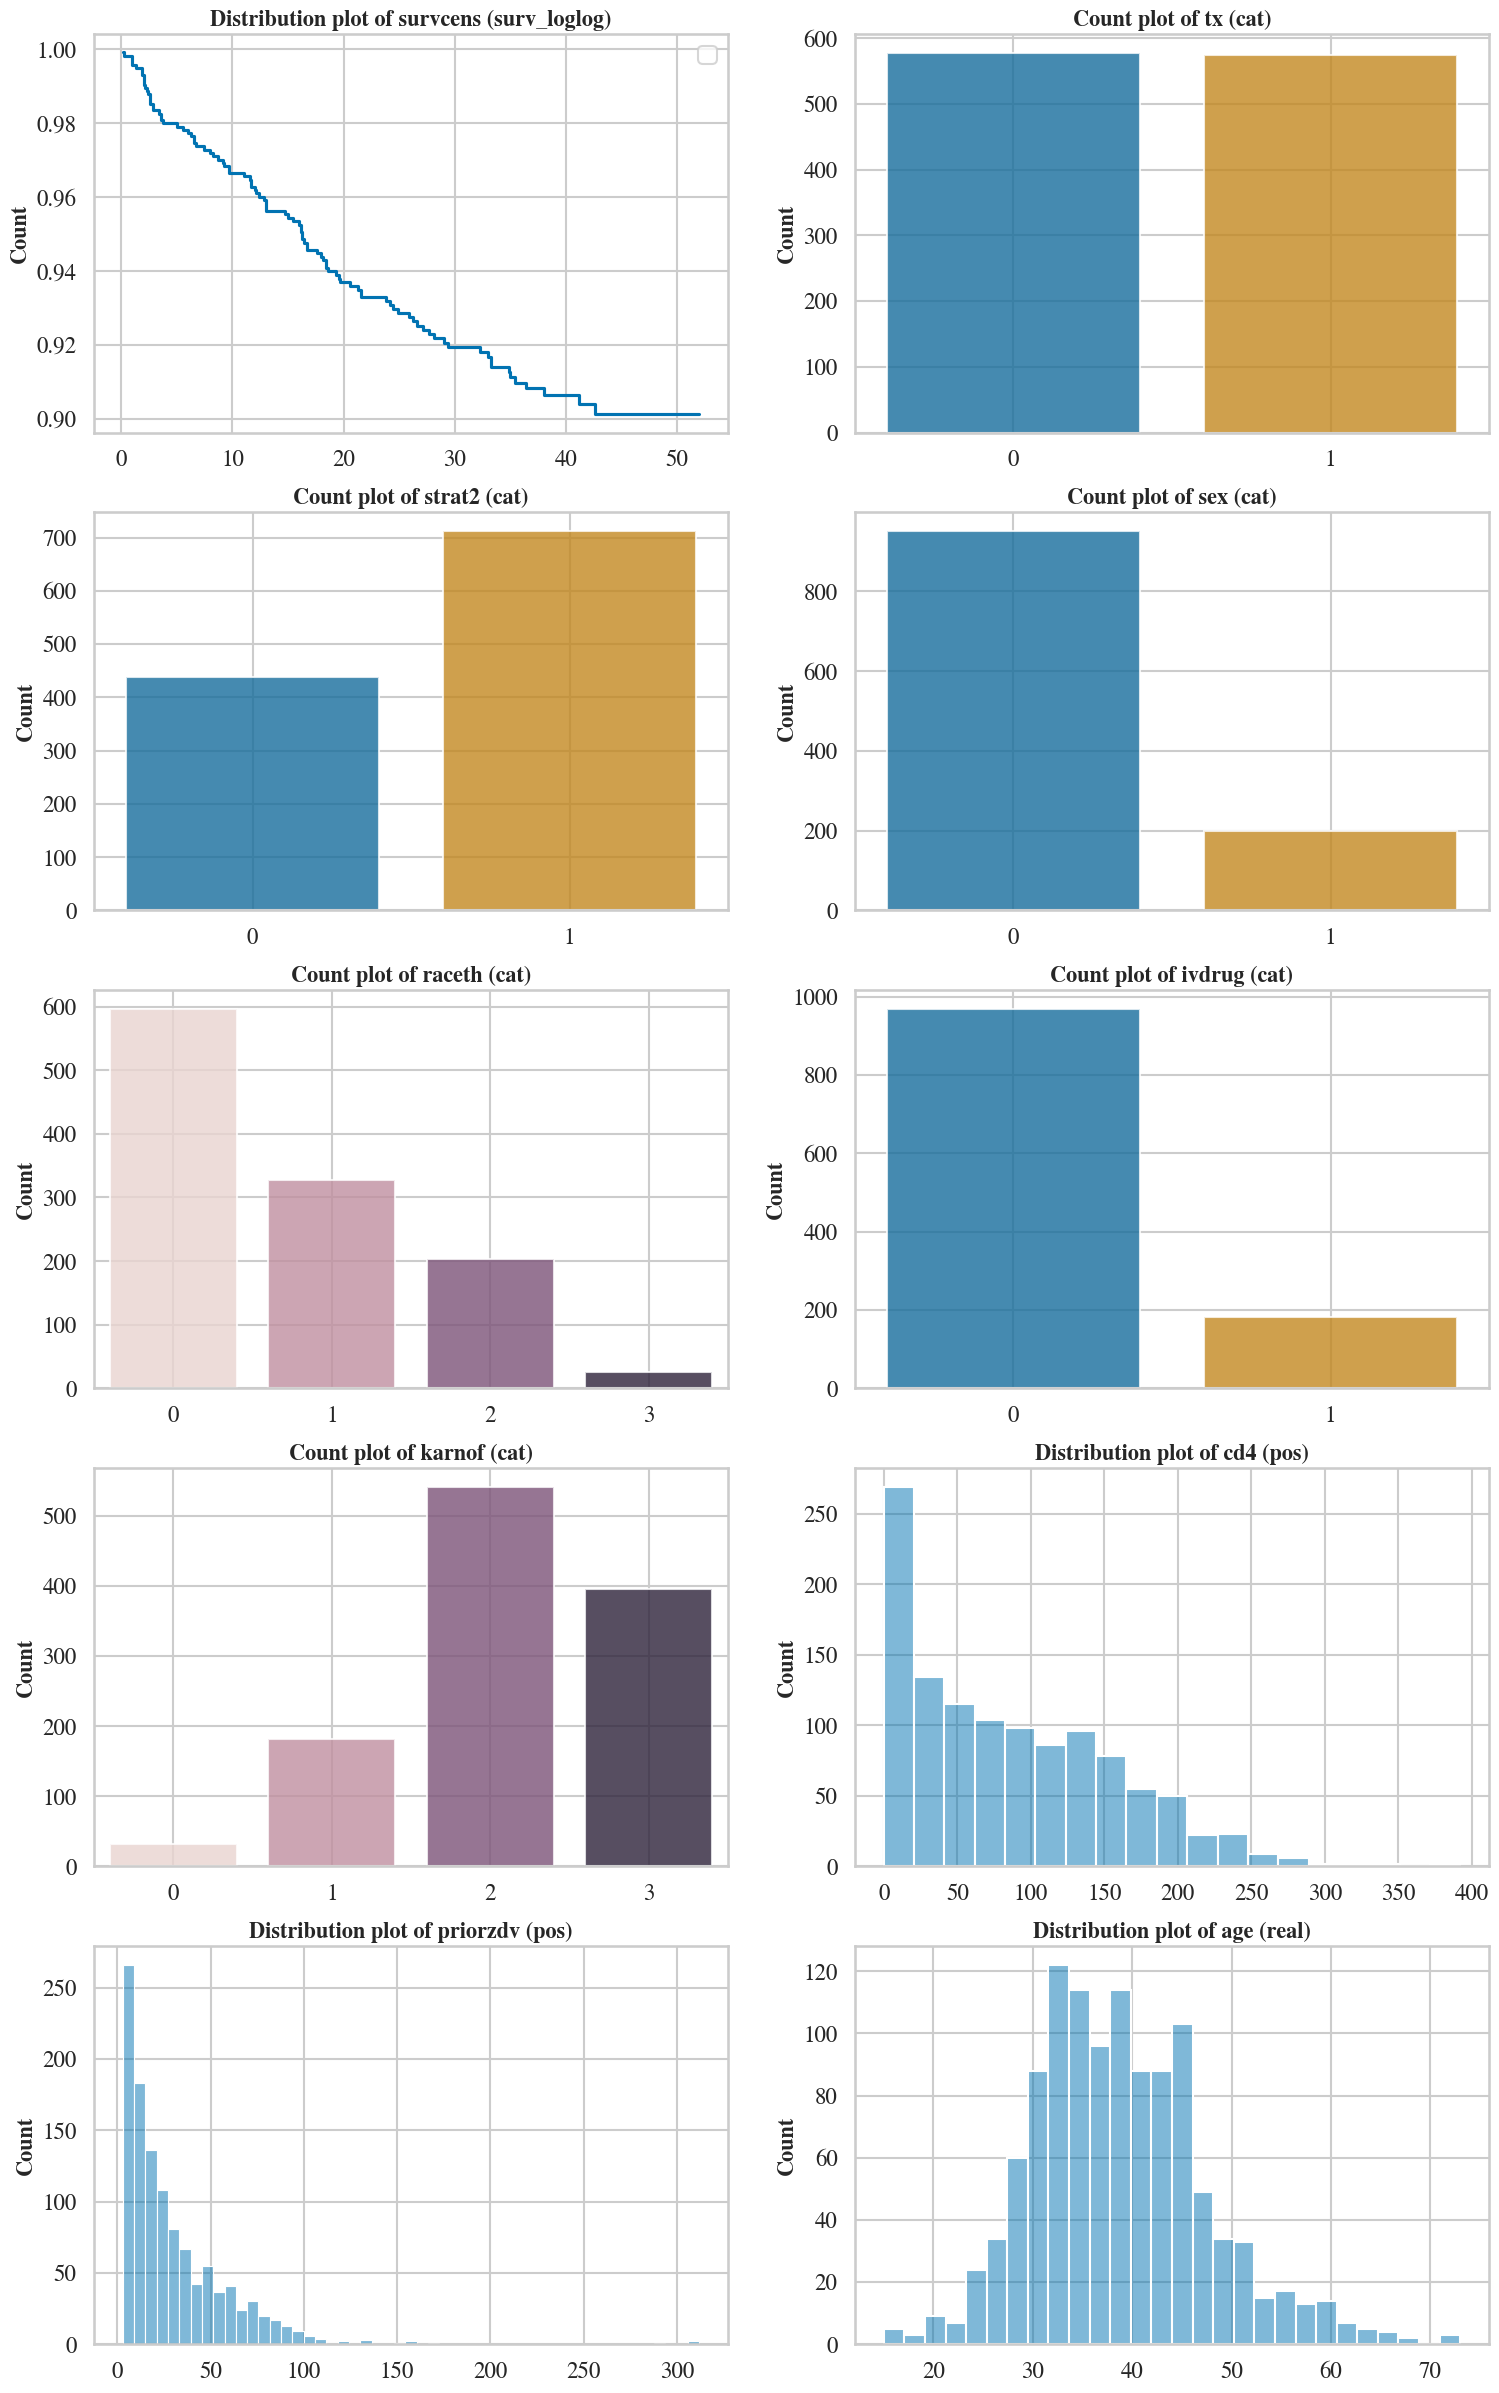

In [25]:
# Load training data
data, feat_types_dict, miss_mask, true_miss_mask, n_samples = data_processing.read_data(data_file, feat_types_file, miss_file, true_miss_file)

# Feature analysis
data_transformed = data_processing.discrete_variables_transformation(data, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(data_transformed, feat_types_dict )

In [26]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_loglog', 'dim': '2', 'nclass': ''},
 {'name': 'tx', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''}]

### Data to control and treated

In [27]:
HIV_treated = HIV[HIV['tx']==1].drop(["tx"] , axis =1)
HIV_control = HIV[HIV['tx']==0].drop(["tx"] , axis =1)

In [28]:
HIV_control.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,27.000000,0,1,1,1,0,100,169.0,39.0,34
1,41.000000,0,1,2,2,0,90,149.5,15.0,34
3,28.428571,0,1,1,1,0,90,46.0,53.0,48
6,38.571429,0,1,1,2,0,100,54.5,6.0,51
8,39.428571,0,1,1,1,0,100,95.0,7.0,34


In [29]:
HIV_control.shape

(577, 10)

In [30]:
np.sum(HIV_control["censor"])

63

In [31]:
dataset_name = "Aids"
data_file_treated= "dataset/" + dataset_name + "/data_treated.csv"
HIV_treated.to_csv(data_file_treated,header=False,index=False)
data_file_control= "dataset/" + dataset_name + "/data_control.csv"
HIV_control.to_csv(data_file_control,header=False,index=False)


In [32]:
HIV_control.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,27.000000,0,1,1,1,0,100,169.0,39.0,34
1,41.000000,0,1,2,2,0,90,149.5,15.0,34
3,28.428571,0,1,1,1,0,90,46.0,53.0,48
6,38.571429,0,1,1,2,0,100,54.5,6.0,51
8,39.428571,0,1,1,1,0,100,95.0,7.0,34


In [33]:
HIV_control.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'],
      dtype='object')